STRATEGY 1 : INDICATOR BASED


HERE IS THE CODE FOR NIFTY BANK FOR DAILY TIMEFRAME.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# lOAD AND PREPARE DATA
df = pd.read_csv('datasets/NB_daily.csv') 
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())

                open      high       low     close  volume
date                                                      
2020-01-01  32237.90  32348.00  32057.20  32102.90       0
2020-01-02  32133.15  32465.45  32121.40  32443.85       0
2020-01-03  32326.95  32329.80  31960.40  32069.25       0
2020-01-06  31910.45  31914.45  31170.55  31237.15       0
2020-01-07  31598.05  31851.45  31200.90  31399.40       0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1272 entries, 2020-01-01 to 2025-02-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1272 non-null   float64
 1   high    1272 non-null   float64
 2   low     1272 non-null   float64
 3   close   1272 non-null   float64
 4   volume  1272 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.6 KB


In [4]:
# PARAMETERS FOR TRADE
initial_capital = 1500000  
leverage = 5
capital = initial_capital * leverage
profit_target = 500
stop_loss_long = 75
stop_loss_short = 50
ma_length = 50
slippage_pct = 0.0001  # 0.01%
lot_size = 30

CALCULATING INDICATORS

In [5]:
# LOADING PRE DEFINED LIBRARY AND MODULES

from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator

# CALCULATION FOR INDICATORS
df['rsi'] = RSIIndicator(close=df['close'], window=14).rsi()
macd = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
df['macd_hist'] = macd.macd_diff()
df['macd_increasing'] = df['macd_hist'].diff() > 0
df['macd_decreasing'] = df['macd_hist'].diff() < 0
df['ma'] = SMAIndicator(close=df['close'], window=ma_length).sma_indicator()

DEFNING ENTRY AND EXITS

In [6]:
# GENERATING SIGNALS

df['long_signal'] = (df['rsi'] > 60) & (df['macd_hist'] > 0) & df['macd_increasing'] & (df['close'] > df['ma'])
df['short_signal'] = (df['rsi'] < 40) & (df['macd_hist'] < 0) & df['macd_decreasing'] & (df['close'] < df['ma'])

In [7]:
# CODE FOR BACKTEST 
trades = []
position = None

for i in range(1, len(df)):
    if position is None:
        if df['long_signal'].iloc[i - 1]:
            entry_high = df['high'].iloc[i - 1]
            entry_price = max(df['open'].iloc[i], entry_high)
            entry_price += entry_price * slippage_pct  # Add slippage cost
            position = {'type': 'long', 'entry_price': entry_price, 'entry_date': df.index[i]}

        elif df['short_signal'].iloc[i - 1]:
            entry_low = df['low'].iloc[i - 1]
            entry_price = min(df['open'].iloc[i], entry_low)
            entry_price -= entry_price * slippage_pct  # Add slippage cost
            position = {'type': 'short', 'entry_price': entry_price, 'entry_date': df.index[i]}

    else:
        high = df['high'].iloc[i]
        low = df['low'].iloc[i]
        if position['type'] == 'long':
            if high - position['entry_price'] >= profit_target:
                exit_price = position['entry_price'] + profit_target
                exit_price -= exit_price * slippage_pct
                pnl = exit_price - position['entry_price']
                trades.append({**position, 'exit_price': exit_price, 'exit_date': df.index[i], 'pnl': pnl})
                position = None
            elif position['entry_price'] - low >= stop_loss_long:
                exit_price = position['entry_price'] - stop_loss_long
                exit_price -= exit_price * slippage_pct
                pnl = exit_price - position['entry_price']
                trades.append({**position, 'exit_price': exit_price, 'exit_date': df.index[i], 'pnl': pnl})
                position = None

        elif position['type'] == 'short':
            if position['entry_price'] - low >= profit_target:
                exit_price = position['entry_price'] - profit_target
                exit_price += exit_price * slippage_pct
                pnl = position['entry_price'] - exit_price
                trades.append({**position, 'exit_price': exit_price, 'exit_date': df.index[i], 'pnl': pnl})
                position = None
            elif high - position['entry_price'] >= stop_loss_short:
                exit_price = position['entry_price'] + stop_loss_short
                exit_price += exit_price * slippage_pct
                pnl = position['entry_price'] - exit_price
                trades.append({**position, 'exit_price': exit_price, 'exit_date': df.index[i], 'pnl': pnl})
                position = None


In [8]:
# ANALIZE TRADE
trades_df = pd.DataFrame(trades)
trades_df['capital_used'] = capital
trades_df['return_pct'] = trades_df['pnl'] / trades_df['entry_price']
trades_df['returns'] = trades_df['return_pct'] * trades_df['capital_used']
trades_df['equity'] = initial_capital + trades_df['returns'].cumsum()
trades_df.set_index('exit_date', inplace=True)

FOR DELIVERABLES CODE FOR MATRICS

In [9]:
# CALCUTION OF METRICS
daily_returns = trades_df['returns'] / initial_capital
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
max_drawdown = (trades_df['equity'].cummax() - trades_df['equity']).max()
drawdown_duration = (trades_df['equity'].cummax() != trades_df['equity']).sum()
cagr = (trades_df['equity'].iloc[-1] / initial_capital) ** (252 / len(trades_df)) - 1
calmar_ratio = (trades_df['equity'].iloc[-1] - initial_capital) / max_drawdown if max_drawdown != 0 else np.nan
win_rate = (trades_df['pnl'] > 0).mean()
trade_frequency = len(trades_df) / ((df.index[-1] - df.index[0]).days / 30)

In [10]:
# MONTHLY RETURNS
monthly_returns = trades_df['returns'].resample('ME').sum()

In [11]:
# PRINTING THE METRICS
print(f"Total Trades: {len(trades_df)}")
print(f"Total Profit/Loss: ₹{trades_df['returns'].sum():,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Max Drawdown: ₹{max_drawdown:,.2f}")
print(f"Drawdown Duration (days): {drawdown_duration}")
print(f"CAGR: {cagr:.2%}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Trade Frequency (trades/month): {trade_frequency:.2f}")


Total Trades: 170
Total Profit/Loss: ₹2,646,401.13
Sharpe Ratio: 4.55
Calmar Ratio: 11.08
Max Drawdown: ₹238,798.40
Drawdown Duration (days): 136
CAGR: 351.42%
Win Rate: 24.71%
Trade Frequency (trades/month): 2.74


PLOTTING THE CURVES

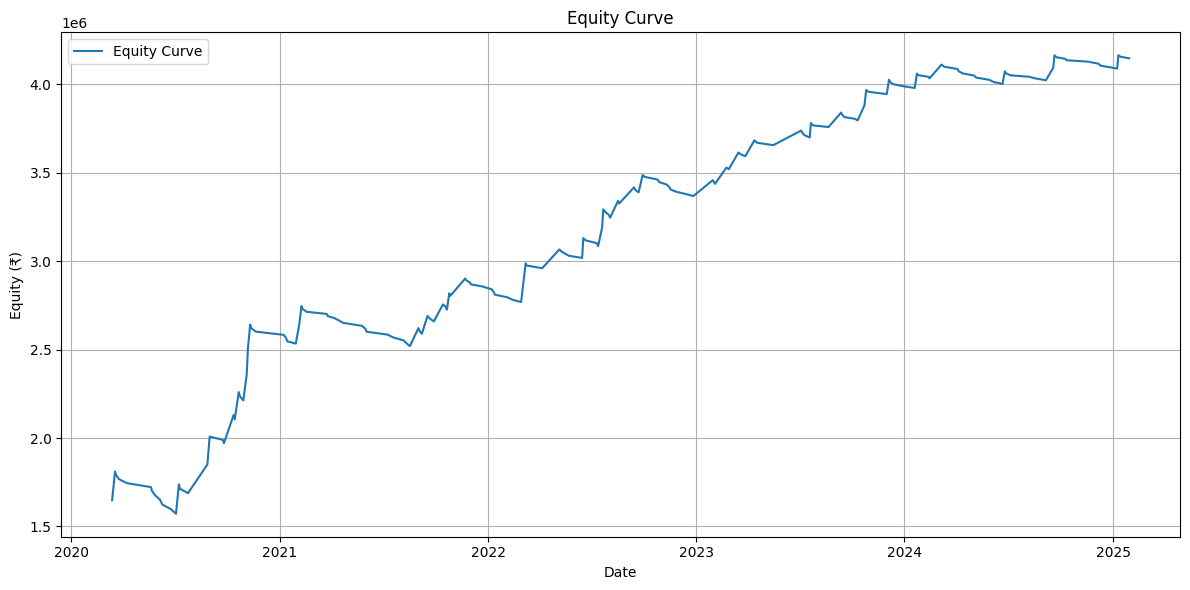

In [12]:
# EQUITY CURVE PLOTING

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(trades_df['equity'], label='Equity Curve')
plt.title("Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


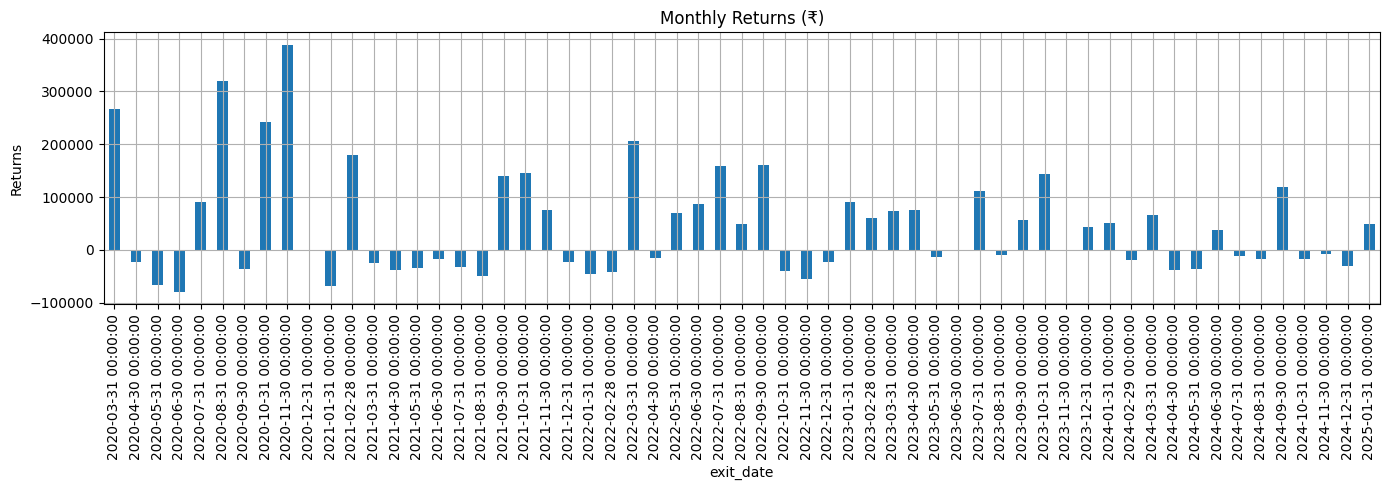

In [13]:
# PLOT MONTH PERFORMANCE

monthly_returns.plot(kind='bar', figsize=(14, 5), title='Monthly Returns (₹)')
plt.grid(True)
plt.ylabel('Returns')
plt.tight_layout()
plt.show()